### Download test files

In [19]:
! wget --quiet https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_49/gencode.v49.annotation.gff3.gz -P ../data/

### Convert to blocked gzip and index (needed for parallel reading)

In [20]:
%%sh
cd ../data
gunzip -c gencode.v49.annotation.gff3.gz  | bgzip -c > gencode.v49.annotation.gff3.bgz
bgzip -r gencode.v49.annotation.gff3.bgz
ls -ltr ../data

total 559840
-rw-r--r--@ 1 mwiewior  staff  118467206 Sep  2 18:44 gencode.v49.annotation.gff3.gz
-rw-r--r--@ 1 mwiewior  staff        570 Sep 14 12:19 test.gff
-rw-r--r--@ 1 mwiewior  staff  145877928 Sep 15 13:25 gencode.v49.annotation.gff3.bgz
-rw-r--r--@ 1 mwiewior  staff     823176 Sep 15 13:25 gencode.v49.annotation.gff3.bgz.gzi


### Read GFF file with polars-Bio

In [23]:
import polars_bio as pb
import polars as pl

In [24]:
print(pb.__version__)

0.17.2


In [25]:
bgz_path = "../data/gencode.v49.annotation.gff3.bgz"

In [26]:
gff_gz = pb.scan_gff("../data/gencode.v49.annotation.gff3.gz")

In [31]:
%%time
gff_gz.limit(1).collect()

0rows [00:00, ?rows/s]

CPU times: user 23.3 ms, sys: 5.64 ms, total: 28.9 ms
Wall time: 27.5 ms


chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chr1""",11121,24894,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000290825.2""}, {""gene_id"",""ENSG00000290825.2""}, … {""tag"",""overlaps_pseudogene""}]"


In [28]:
gff = pb.scan_gff(bgz_path)

In [32]:
%%time
gff.limit(1).collect()

0rows [00:00, ?rows/s]

CPU times: user 28.6 ms, sys: 5.95 ms, total: 34.5 ms
Wall time: 30.4 ms


chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chr1""",11121,24894,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000290825.2""}, {""gene_id"",""ENSG00000290825.2""}, … {""tag"",""overlaps_pseudogene""}]"


In [33]:
%%time
gff.count().collect()

0rows [00:00, ?rows/s]

CPU times: user 13.3 s, sys: 645 ms, total: 13.9 s
Wall time: 11.8 s


chrom,start,end,type,source,score,strand,phase,attributes
u32,u32,u32,u32,u32,u32,u32,u32,u32
7747875,7747875,7747875,7747875,7747875,0,7747875,2720577,7747875


### Parallel reading

In [35]:
gff = pb.scan_gff(bgz_path, parallel=True)

In [36]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [37]:
%%time
gff.count().collect()

0rows [00:00, ?rows/s]

CPU times: user 12.8 s, sys: 251 ms, total: 13.1 s
Wall time: 2.88 s


chrom,start,end,type,source,score,strand,phase,attributes
u32,u32,u32,u32,u32,u32,u32,u32,u32
7747875,7747875,7747875,7747875,7747875,0,7747875,2720577,7747875


### Projection and predicate and pushdown optimizations

#### Projection pushdown

In [38]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [39]:
%%time
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=False).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

CPU times: user 11.9 s, sys: 584 ms, total: 12.4 s
Wall time: 12.1 s


chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chrM""",15888,15953
"""chrM""",15888,15953
"""chrM""",15956,16023


In [40]:
%%time
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=True).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

CPU times: user 6.93 s, sys: 159 ms, total: 7.09 s
Wall time: 6.94 s


chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chrM""",15888,15953
"""chrM""",15888,15953
"""chrM""",15956,16023


#### Increase parallelism

In [43]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [44]:
%%time
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=True).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

CPU times: user 7.82 s, sys: 174 ms, total: 8 s
Wall time: 1.96 s


chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chr16""",14446888,14447081
"""chr16""",14435704,14436772
"""chr16""",14436717,14436772


In [45]:
pb.set_option("datafusion.execution.target_partitions", "8")

In [46]:
%%time
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=True).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

CPU times: user 7.97 s, sys: 171 ms, total: 8.14 s
Wall time: 1.01 s


chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chr16""",14446888,14447081
"""chr16""",14435704,14436772
"""chr16""",14436717,14436772


#### Predicate pushdown

In [47]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [48]:
lf = pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=False).filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)

In [49]:
%%time
lf.collect()

0rows [00:00, ?rows/s]

CPU times: user 11.8 s, sys: 259 ms, total: 12 s
Wall time: 11.6 s


chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chrY""",386962,511616,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000292349.2""}, {""gene_id"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"
"""chrY""",387035,511616,"""transcript""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENST00000972808.1""}, {""Parent"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"


In [50]:
lf = pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=True).filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)

In [51]:
%%time
lf.collect()

0rows [00:00, ?rows/s]

CPU times: user 4 s, sys: 43.3 ms, total: 4.04 s
Wall time: 4.04 s


chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chrY""",386962,511616,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000292349.2""}, {""gene_id"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"
"""chrY""",387035,511616,"""transcript""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENST00000972808.1""}, {""Parent"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"


#### Increase parallelism

In [52]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [53]:
%%time
lf.collect()

0rows [00:00, ?rows/s]

CPU times: user 4.57 s, sys: 35 ms, total: 4.6 s
Wall time: 1.17 s


chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chrY""",386962,511616,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000292349.2""}, {""gene_id"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"
"""chrY""",387035,511616,"""transcript""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENST00000972808.1""}, {""Parent"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"


#### Combine projection and predicate pushdown

In [54]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [55]:
%%time
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=False, projection_pushdown=False)
.select(["chrom", "start", "end", "ID"])
).collect()

0rows [00:00, ?rows/s]

CPU times: user 7.61 s, sys: 189 ms, total: 7.8 s
Wall time: 7.66 s


chrom,start,end,ID
str,u32,u32,str
"""chr1""",11121,24894,"""ENSG00000290825.2"""
"""chr1""",11121,14413,"""ENST00000832824.1"""
"""chr1""",11121,11211,"""exon:ENST00000832824.1:1"""
"""chr1""",12010,12227,"""exon:ENST00000832824.1:2"""
"""chr1""",12613,12721,"""exon:ENST00000832824.1:3"""
…,…,…,…
"""chrM""",15888,15953,"""ENST00000387460.2"""
"""chrM""",15888,15953,"""exon:ENST00000387460.2:1"""
"""chrM""",15956,16023,"""ENSG00000210196.2"""


In [56]:
%%time
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=False, projection_pushdown=False)
.select(["chrom", "start", "end", "ID"])
.filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)).collect()

0rows [00:00, ?rows/s]

CPU times: user 7.71 s, sys: 181 ms, total: 7.9 s
Wall time: 7.65 s


chrom,start,end,ID
str,u32,u32,str
"""chrY""",386962,511616,"""ENSG00000292349.2"""
"""chrY""",387035,511616,"""ENST00000972808.1"""


In [57]:
%%time
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=True, projection_pushdown=True)
.select(["chrom", "start", "end", "ID"])
.filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)).collect()

0rows [00:00, ?rows/s]

CPU times: user 4.06 s, sys: 45.4 ms, total: 4.11 s
Wall time: 4.1 s


chrom,start,end,ID
str,u32,u32,str
"""chrY""",386962,511616,"""ENSG00000292349.2"""
"""chrY""",387035,511616,"""ENST00000972808.1"""


In [58]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [59]:
%%time
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=True, projection_pushdown=True)
.select(["chrom", "start", "end", "ID"])
.filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)).collect()

0rows [00:00, ?rows/s]

CPU times: user 4.53 s, sys: 35.9 ms, total: 4.57 s
Wall time: 1.16 s


chrom,start,end,ID
str,u32,u32,str
"""chrY""",386962,511616,"""ENSG00000292349.2"""
"""chrY""",387035,511616,"""ENST00000972808.1"""


### Overlaps

In [62]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [64]:
df = pb.scan_gff(bgz_path, projection_pushdown=True,
                 parallel=True).select(["chrom", "start", "end", "ID", "type"])
df2 = pb.scan_gff(bgz_path, projection_pushdown=True,
                  parallel=True).select(["chrom", "start", "end", "source"])

In [65]:
%%time
pb.overlap(df, df2, suffixes=("_left","_right")).limit(10).collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

CPU times: user 17.2 s, sys: 545 ms, total: 17.7 s
Wall time: 15.6 s


chrom_left,start_left,end_left,ID_left,type_left,chrom_right,start_right,end_right,source_right
str,u32,u32,str,str,str,u32,u32,str
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,16788,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,16788,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,16788,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,18061,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",14407,14829,"""HAVANA"""


In [66]:
%%time
pb.overlap(df, df2).count().collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

CPU times: user 26.1 s, sys: 1.53 s, total: 27.6 s
Wall time: 24.8 s


chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


In [67]:
%%time
pb.overlap(df, df2).filter( (pl.col("type_1") == "gene") & (pl.col("chrom_1") == "chrX") ).collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

CPU times: user 27.5 s, sys: 1.35 s, total: 28.9 s
Wall time: 23.9 s


chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
str,u32,u32,str,str,str,u32,u32,str
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",253743,253846,"""HAVANA"""
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",253743,255091,"""HAVANA"""
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",253743,255091,"""HAVANA"""
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",254937,255091,"""HAVANA"""
"""chrX""",267677,276210,"""ENSG00000303837.1""","""gene""","""chrX""",267677,267868,"""HAVANA"""
…,…,…,…,…,…,…,…,…
"""chrX""",156025664,156027877,"""ENSG00000227159.8""","""gene""","""chrX""",156027830,156028047,"""HAVANA"""
"""chrX""",156025664,156027877,"""ENSG00000227159.8""","""gene""","""chrX""",156027830,156028047,"""HAVANA"""
"""chrX""",156025664,156027877,"""ENSG00000227159.8""","""gene""","""chrX""",156027830,156028047,"""HAVANA"""


In [68]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [69]:
%%time
pb.overlap(df, df2).count().collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

CPU times: user 29.6 s, sys: 4.68 s, total: 34.3 s
Wall time: 8.16 s


chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


In [71]:
pb.set_option("datafusion.execution.target_partitions", "8")

In [72]:
%%time
pb.overlap(df, df2).count().collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

CPU times: user 30.6 s, sys: 5.94 s, total: 36.6 s
Wall time: 5.18 s


chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


In [73]:
%%time
pb.overlap(df, df2).sink_parquet("/tmp/test.parquet")

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

CPU times: user 1min 59s, sys: 28.9 s, total: 2min 28s
Wall time: 19.1 s


In [74]:
par_lf = pl.scan_parquet("/tmp/test.parquet")

In [75]:
par_lf.limit(1).collect()

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
str,u32,u32,str,str,str,u32,u32,str
"""chr2""",37646588,37646822,"""UTR5:ENST00000885384.1""","""five_prime_UTR""","""chr2""",37600193,37662091,"""HAVANA"""


In [76]:
par_lf.count().collect()

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


### Memory usage considerations

In [77]:
%%sh
rm -f overlap_coordinates_only.dat overlap_coordinates_only.png
mprof run --output overlap_coordinates_only.dat src/overlap_coordinates_only.py 2> /dev/null
mprof peak overlap_coordinates_only.dat
mprof plot overlap_coordinates_only.dat --output overlap_coordinates_only.png

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
overlap_coordinates_only.dat	1508.453 MiB


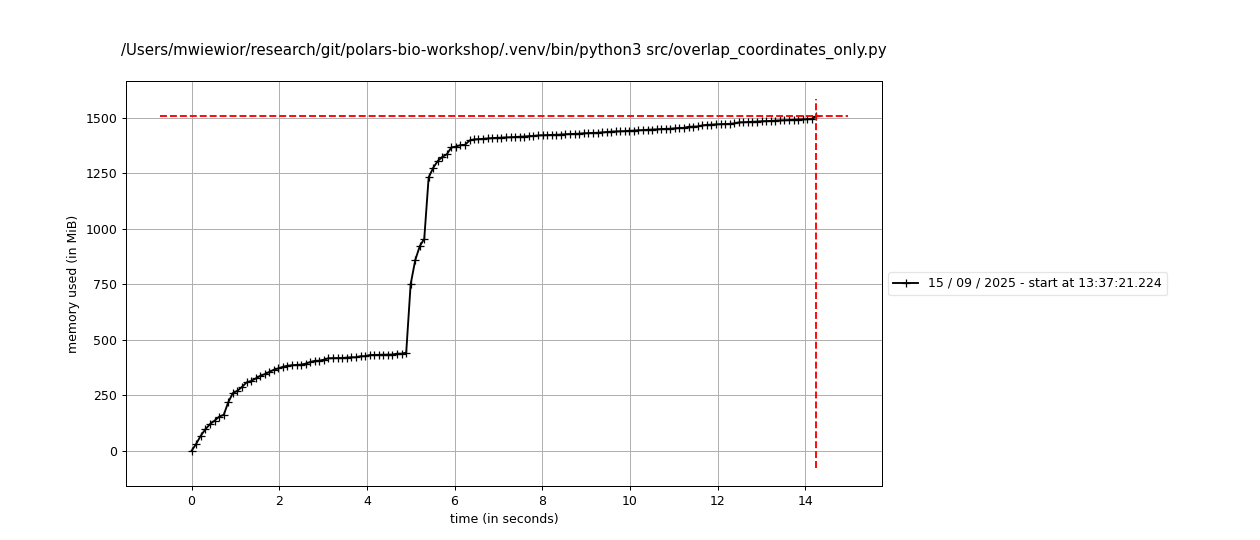

In [78]:
from IPython.display import Image
Image("overlap_coordinates_only.png")

In [79]:
%%sh
rm -f overlap.dat overlap.png
mprof run --output overlap.dat src/overlap.py 2> /dev/null
mprof peak overlap.dat
mprof plot overlap.dat --output overlap.png

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
overlap.dat	20251.938 MiB


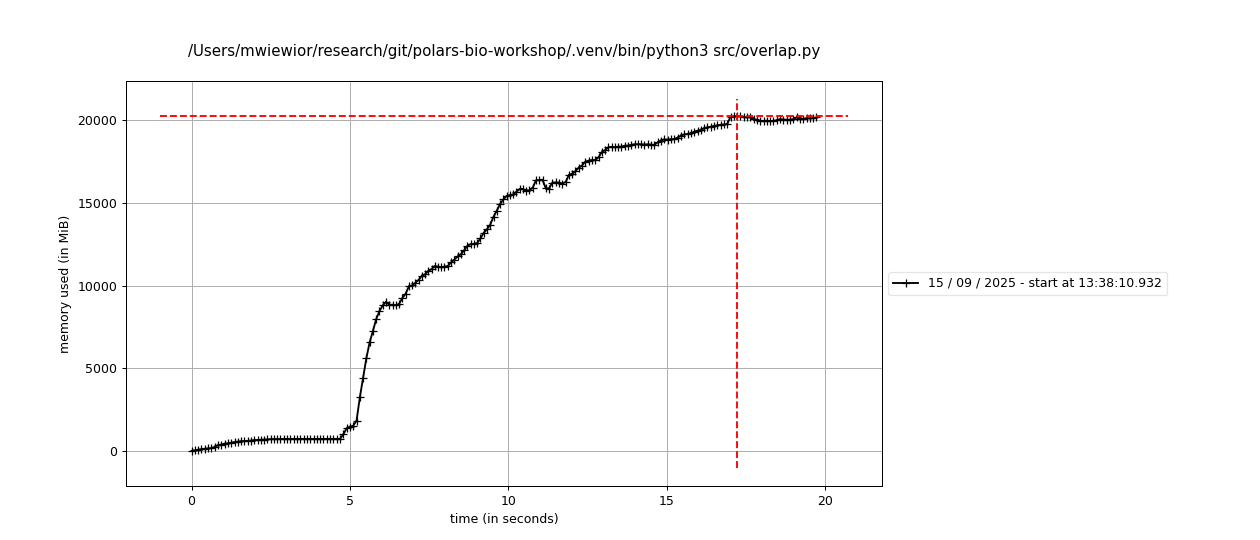

In [80]:
from IPython.display import Image
Image("overlap.png")

In [81]:
%%sh
rm -f overlap_low_memory.dat overlap_low_memory.png
mprof run --output overlap_low_memory.dat src/overlap_low_memory.py 2> /dev/null
mprof peak overlap_low_memory.dat
mprof plot overlap_low_memory.dat --output overlap_low_memory.png

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
overlap_low_memory.dat	3193.516 MiB


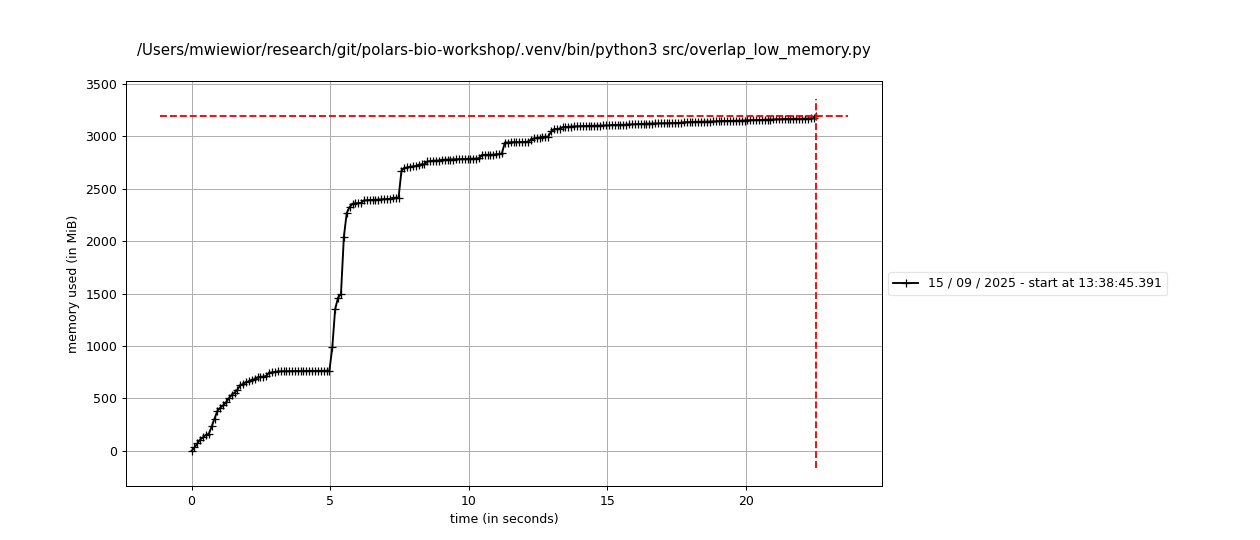

In [83]:
from IPython.display import Image
Image("overlap_low_memory.png")

In [87]:
! du -h /tmp/test.parquet

192M	/tmp/test.parquet


In [84]:
ldf = pl.scan_parquet("/tmp/test.parquet")

In [85]:
ldf.limit(1).collect()

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
str,u32,u32,str,str,str,u32,u32,str
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""


In [86]:
ldf.count().collect()

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299
